# Рейтинг фильмов

# Постановка задачи

Нужно проанализировать зависимость успешности фильма (его рейтинг) от его возрастного ограничения, жанра, длительности и набора актёров в нём. 

# Подключение модулей

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import parse_actors

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Загрузка данных

In [20]:
df = pd.read_csv('2_imdb_1000.csv', sep = ',')

In [21]:
df.head()

,star_rating,title,content_rating,genre,duration,actors_list
0,9.3,The Shawshank Redemption,R,Crime,142,"[u'Tim Robbins', u'Morgan Freeman', u'Bob Gunt..."
1,9.2,The Godfather,R,Crime,175,"[u'Marlon Brando', u'Al Pacino', u'James Caan']"
2,9.1,The Godfather: Part II,R,Crime,200,"[u'Al Pacino', u'Robert De Niro', u'Robert Duv..."
3,9.0,The Dark Knight,PG-13,Action,152,"[u'Christian Bale', u'Heath Ledger', u'Aaron E..."
4,8.9,Pulp Fiction,R,Crime,154,"[u'John Travolta', u'Uma Thurman', u'Samuel L...."


# Описание данных

#### Признаки:

- star_rating – рейтинг в «звёздах»;
- title – название;
- content_rating - возрастное ограничение;
- genre - жанр;
- duration - длительность в минутах;
- actors_list - список участвующих актёров;

# Изучение данных

In [22]:
df.shape

(979, 6)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   star_rating     979 non-null    float64
 1   title           979 non-null    object 
 2   content_rating  976 non-null    object 
 3   genre           979 non-null    object 
 4   duration        979 non-null    int64  
 5   actors_list     979 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 46.0+ KB


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
star_rating,979.0,7.889785,0.336069,7.4,7.6,7.8,8.1,9.3
duration,979.0,120.979571,26.218010,64.0,102.0,117.0,134.0,242.0


In [25]:
df.describe(include='O').T

,count,unique,top,freq
title,979,975,The Girl with the Dragon Tattoo,2
content_rating,976,12,R,460
genre,979,16,Drama,278
actors_list,979,969,"[u'Daniel Radcliffe', u'Emma Watson', u'Rupert...",6


## Вывод:

Набор данных содержит в себе 979 записей. Есть пропущенные значения. 
- Средний рейтинг фильма - 7.8 «звёзд».
- Средняя длительность - 117 минут.
- Самый популярный жанр - драма.
- Большинство из фильмов имеет возрастное ограничение - «R», то есть показ запрещён лицам младше 16-ти лет.

# Разведочный анализ данных (EDA)

#### Проверка на пропущенные и дублирующиеся значения.

In [26]:
df.isna().sum()

star_rating       0
title             0
content_rating    3
genre             0
duration          0
actors_list       0
dtype: int64

In [27]:
df.duplicated().sum()

np.int64(0)

#### Вывод:

В наборе данных есть три пропущенных значения в признаке «content_rating».
> Заполним пропущенные значения, значением «Unkown», так как присваивание популярного значения неверно в контексте.

In [28]:
df['content_rating'].fillna('Unknown', inplace=True)

Напишем скрипт `parse_actors.py` для десериализации списка актёров.

```Python
import ast
from collections import Counter

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def parse_actors(actors_str):
    """
    Парсит строковое представление списка актёров.
    Возвращает Python-список актёров.
    """

    if pd.isna(actors_str):
        return []
    
    cleaned_actors_str = str(actors_str).replace("u'", "'").replace('u"', '"').strip()

    try:
        parsed = ast.literal_eval(cleaned_actors_str)
        if isinstance(parsed, (list, tuple)):
            return [str(actor).strip() for actor in parsed]
        else:
            return [str(parsed).strip()]
    except Exception:
        try:
            temp = cleaned_actors_str.strip()
            if temp.startswith('[') and temp.endswith(']'):
                inner = temp[1:-1]
            else:
                inner = temp
            
            for sep in ["', '", '", "', '", \'', "\', \""]:
                inner = inner.replace(sep, '||SEP||')
            parts = [part.strip(" '\"") for part in inner.split('||SEP||') if part.strip(" '\"")]
            return parts
        except Exception:
            return [cleaned_actors_str]
```

In [29]:
df['actors_parsed'] = df['actors_list'].apply(parse_actors.parse_actors)
df.drop('actors_list', axis=1, inplace=True)

In [30]:
df.head()

,star_rating,title,content_rating,genre,duration,actors_parsed
0,9.3,The Shawshank Redemption,R,Crime,142,"[Tim Robbins, Morgan Freeman, Bob Gunton]"
1,9.2,The Godfather,R,Crime,175,"[Marlon Brando, Al Pacino, James Caan]"
2,9.1,The Godfather: Part II,R,Crime,200,"[Al Pacino, Robert De Niro, Robert Duvall]"
3,9.0,The Dark Knight,PG-13,Action,152,"[Christian Bale, Heath Ledger, Aaron Eckhart]"
4,8.9,Pulp Fiction,R,Crime,154,"[John Travolta, Uma Thurman, Samuel L. Jackson]"


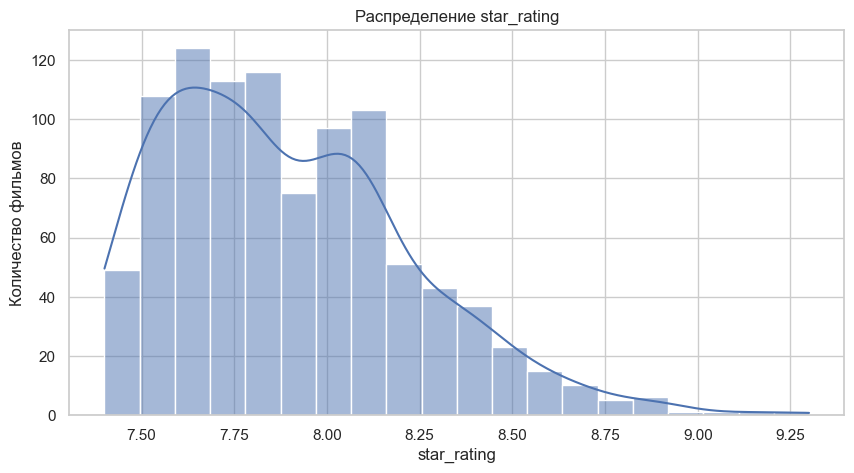

In [34]:
plt.figure()
sns.histplot(df['star_rating'].dropna(), bins=20, kde=True)
plt.title('Распределение star_rating')
plt.xlabel('star_rating')
plt.ylabel('Количество фильмов')
plt.show()

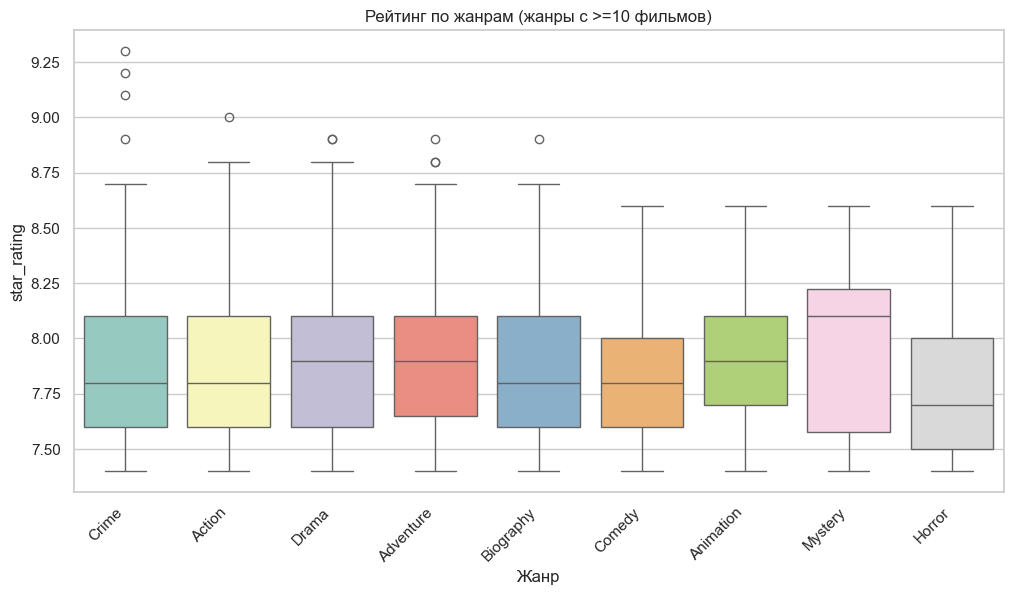

In [36]:
# Оставляем только жанры с достаточным количеством фильмов для читабельности графика.
genre_counts = df['genre'].value_counts()
popular_genres = genre_counts[genre_counts >= 10].index.tolist()

# Boxplot рейтинга по жанрам (только популярные жанры).
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df['genre'].isin(popular_genres)],
    x='genre',
    y='star_rating',
    palette='Set3'
)
plt.xticks(rotation=45, ha='right')
plt.title('Рейтинг по жанрам (жанры с >=10 фильмов)')
plt.xlabel('Жанр')
plt.ylabel('star_rating')
plt.show()

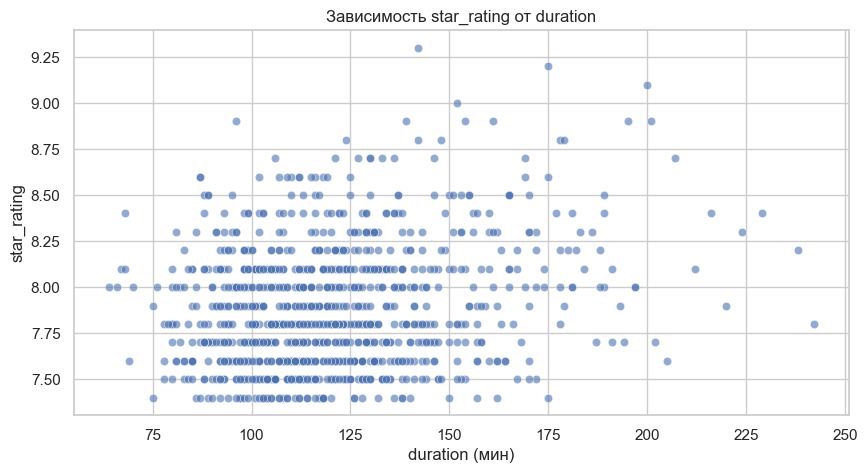

In [38]:
plt.figure()
sns.scatterplot(data=df, x='duration', y='star_rating', alpha=0.6)
plt.title('Зависимость star_rating от duration')
plt.xlabel('duration (мин)')
plt.ylabel('star_rating')
plt.show()

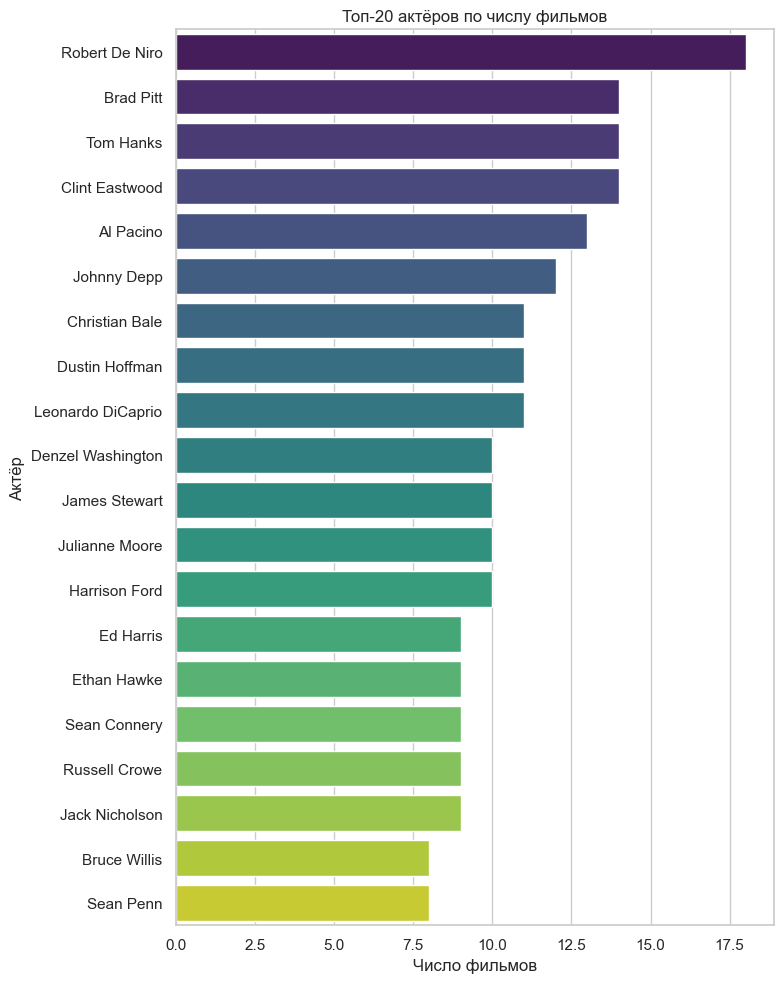

In [39]:
# Разворачиваем список актёров в строки и считаем частоты.
actors_exploded = df.explode('actors_parsed')
actors_exploded['actors_parsed'] = actors_exploded['actors_parsed'].astype(str).str.strip()
actor_counts = actors_exploded['actors_parsed'].value_counts().head(20)

plt.figure(figsize=(8,10))
sns.barplot(x=actor_counts.values, y=actor_counts.index, palette='viridis')
plt.title('Топ-20 актёров по числу фильмов')
plt.xlabel('Число фильмов')
plt.ylabel('Актёр')
plt.tight_layout()
plt.show()

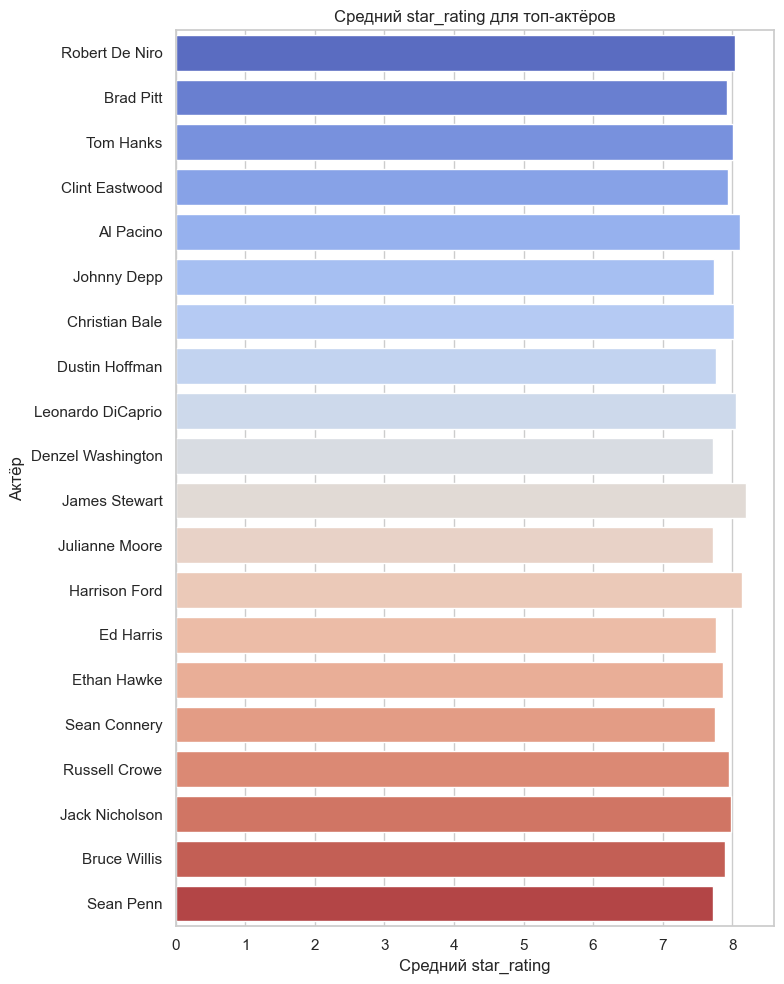

In [40]:
top_actors = actor_counts.index.tolist()
avg_rating_by_actor = actors_exploded.groupby('actors_parsed')['star_rating'].mean().reindex(top_actors)

plt.figure(figsize=(8,10))
sns.barplot(x=avg_rating_by_actor.values, y=avg_rating_by_actor.index, palette='coolwarm')
plt.title('Средний star_rating для топ-актёров')
plt.xlabel('Средний star_rating')
plt.ylabel('Актёр')
plt.tight_layout()
plt.show()

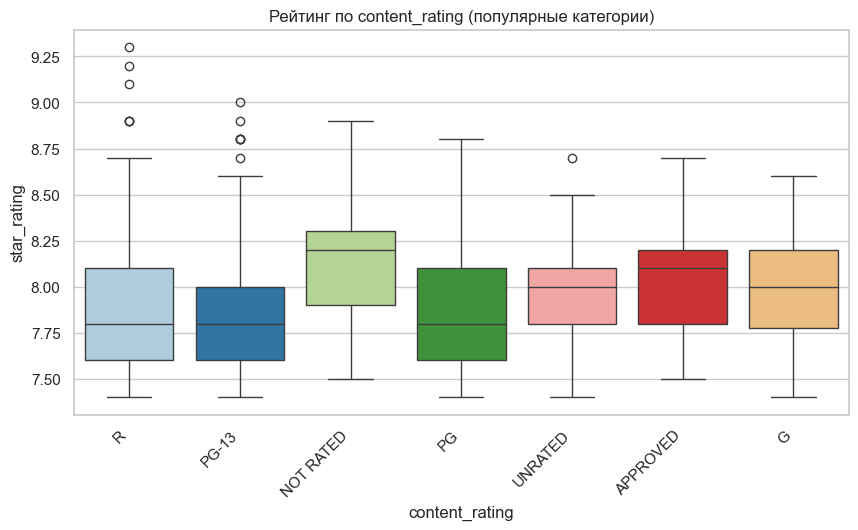

In [46]:
# Для удобства фильтруем только популярные content_rating (>=10 экземпляров).
cr_counts = df['content_rating'].value_counts()
popular_cr = cr_counts[cr_counts >= 10].index.tolist()
sns.boxplot(data=df[df['content_rating'].isin(popular_cr)], x='content_rating', y='star_rating', palette='Paired')
plt.xticks(rotation=45, ha='right')
plt.title('Рейтинг по content_rating (популярные категории)')
plt.xlabel('content_rating')
plt.ylabel('star_rating')
plt.show()

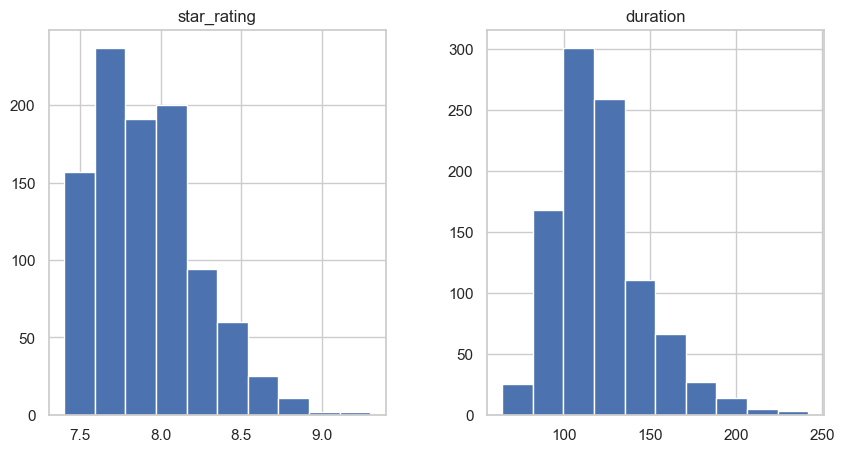

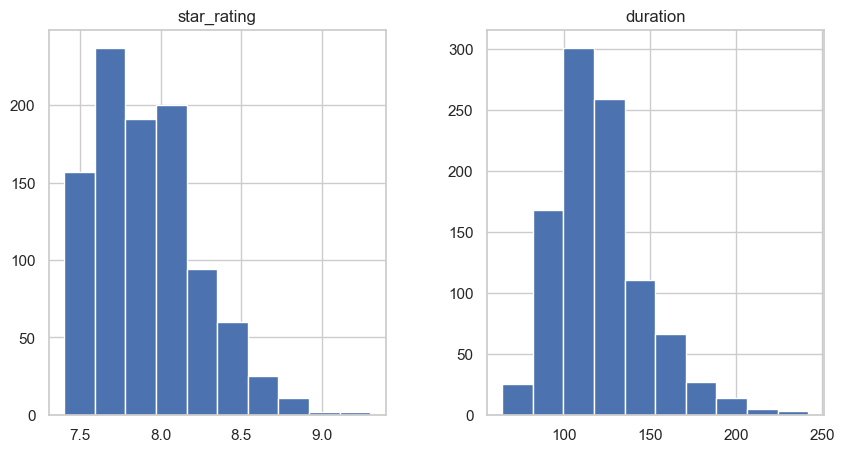

In [55]:
df.hist()
plt.show()

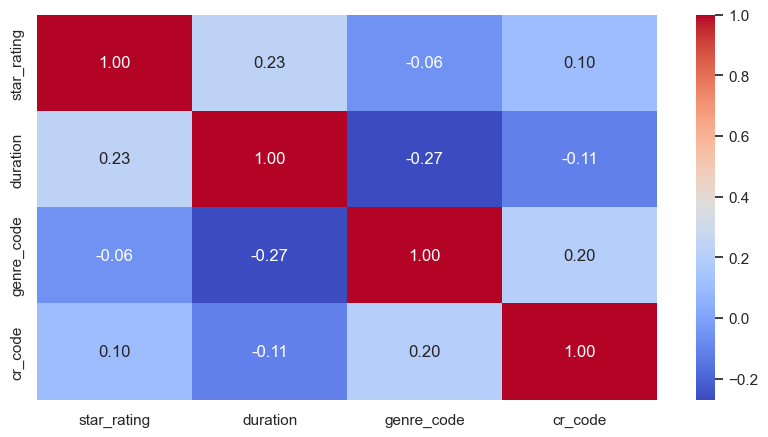

In [53]:
df2 = df.assign(genre_code=pd.factorize(df['genre'])[0].astype(float), cr_code=pd.factorize(df['content_rating'])[0].astype(float))[['star_rating','duration','genre_code','cr_code']];
sns.heatmap(df2.corr(), annot=True, fmt='.2f', cmap='coolwarm'); 
plt.show()

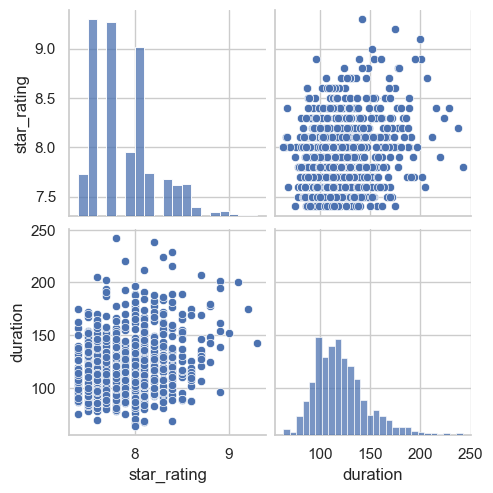

In [58]:
sns.pairplot(df)
plt.show()

# Вывод:

- В основном рейтинг фильмов от 7.5 до 8.20.
- Основные жанры популярных фильмов: Crime, Action, Adventure.
- Большинство популярных фильмов имеет длительность от 125 до 200 минут.
- Наличие актёра James Stewart обычно приводит к высокому рейтингу фильма.
- Большинство популярных фильмов имеет возрастное ограничение R или PG-13.